In [1]:
# from steppy.base import BaseTransformer

In [2]:
import os
import sys
from functools import partial
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns


from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

warnings.filterwarnings('ignore')

DIR = '/PATH/TO/YOUR/DATA'
description = pd.read_csv(('HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')

In [3]:
application.shape

(307511, 122)

In [4]:
description.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [5]:
from IPython.display import display
display(bureau.shape)
display(bureau['AMT_CREDIT_SUM'].head(50))
bureau.head(16)

(1716428, 17)

0       91323.000
1      225000.000
2      464323.500
3       90000.000
4     2700000.000
5      180000.000
6       42103.800
7       76878.450
8      103007.700
9        4500.000
10     337500.000
11     675000.000
12    7033500.000
13      89910.000
14          0.000
15      48555.000
16     135000.000
17     450000.000
18      67500.000
19     107184.060
20     252000.000
21          0.000
22     127840.500
23    1350000.000
24      18157.500
25     675000.000
26    3709552.500
27      39433.500
28      38830.500
29      67500.000
30     182791.440
31     112500.000
32     110250.000
33     180000.000
34      40500.000
35     114727.500
36     225000.000
37     142290.000
38      85288.500
39     100129.500
40      44419.500
41      21690.000
42      85293.000
43     200250.000
44     100129.500
45     159386.085
46      48645.000
47    1058823.540
48     256500.000
49      15921.000
Name: AMT_CREDIT_SUM, dtype: float64

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0       215354       5714462        Closed      currency 1         -497   
1       215354       5714463        Active      currency 1         -208   
2       215354       5714464        Active      currency 1         -203   
3       215354       5714465        Active      currency 1         -203   
4       215354       5714466        Active      currency 1         -629   
5       215354       5714467        Active      currency 1         -273   
6       215354       5714468        Active      currency 1          -43   
7       162297       5714469        Closed      currency 1        -1896   
8       162297       5714470        Closed      currency 1        -1146   
9       162297       5714471        Active      currency 1        -1146   
10      162297       5714472        Active      currency 1        -1146   
11      162297       5714473        Closed      currency 1        -2456   
12      162297       5714474        Active      currency 1         -277   
13      402440       5714475        Active      currency 1          -96   
14      238881       5714482        Closed      currency 1         -318   
15      238881       5714484        Closed      currency 1        -2911   

    CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                    0               -153.0             -153.0   
1                    0               1075.0                NaN   
2                    0                528.0                NaN   
3                    0                  NaN                NaN   
4                    0               1197.0                NaN   
5                    0              27460.0                NaN   
6                    0                 79.0                NaN   
7                    0              -1684.0            -1710.0   
8                    0               -811.0             -840.0   
9                    0               -484.0                NaN   
10                   0               -180.0                NaN   
11                   0               -629.0             -825.0   
12                   0               5261.0                NaN   
13                   0                269.0                NaN   
14                   0               -187.0             -187.0   
15                   0              -2607.0            -2604.0   

    AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                      NaN                   0        91323.00   
1                      NaN                   0       225000.00   
2                      NaN                   0       464323.50   
3                      NaN                   0        90000.00   
4                  77674.5                   0      2700000.00   
5                      0.0                   0       180000.00   
6                      0.0                   0        42103.80   
7                  14985.0                   0        76878.45   
8                      0.0                   0       103007.70   
9                      0.0                   0         4500.00   
10                     0.0                   0       337500.00   
11                     NaN                   0       675000.00   
12                     0.0                   0      7033500.00   
13                     0.0                   0        89910.00   
14                     NaN                   0            0.00   
15                     NaN                   0        48555.00   

    AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.00                   NaN                     0.0   
1             171342.00                   NaN                     0.0   
2                   NaN                   NaN                     0.0   
3                   NaN                   NaN                     0.0   
4                   NaN                   NaN                     0.0   
5              71017.38             108982.6

In [6]:
(bureau['AMT_CREDIT_SUM'] == 0).sum()

66582

In [7]:
bureau[bureau['SK_ID_CURR']==215354]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0           215354       5714462        Closed      currency 1         -497   
1           215354       5714463        Active      currency 1         -208   
2           215354       5714464        Active      currency 1         -203   
3           215354       5714465        Active      currency 1         -203   
4           215354       5714466        Active      currency 1         -629   
5           215354       5714467        Active      currency 1         -273   
6           215354       5714468        Active      currency 1          -43   
225157      215354       5714458        Closed      currency 1        -1872   
225158      215354       5714459        Closed      currency 1        -1734   
225159      215354       5714460        Closed      currency 1        -1333   
225160      215354       5714461        Closed      currency 1        -1011   

        CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                        0               -153.0             -153.0   
1                        0               1075.0                NaN   
2                        0                528.0                NaN   
3                        0                  NaN                NaN   
4                        0               1197.0                NaN   
5                        0              27460.0                NaN   
6                        0                 79.0                NaN   
225157                   0               -776.0            -1203.0   
225158                   0               -638.0            -1336.0   
225159                   0              -1089.0             -987.0   
225160                   0               -830.0             -770.0   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                          NaN                   0         91323.0   
1                          NaN                   0        225000.0   
2                          NaN                   0        464323.5   
3                          NaN                   0         90000.0   
4                      77674.5                   0       2700000.0   
5                          0.0                   0        180000.0   
6                          0.0                   0         42103.8   
225157                     NaN                   0        494550.0   
225158                     NaN                   0       1084032.0   
225159                     NaN                   0        102150.0   
225160                     NaN                   0        500463.0   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                      0.00                   NaN                     0.0   
1                 171342.00                   NaN                     0.0   
2                       NaN                   NaN                     0.0   
3                       NaN                   NaN                     0.0   
4                       NaN                   NaN                     0.0   
5                  71017.38             108982.62                     0.0   
6                  42103.80                  0.00                     0.0   
225157                 0.00                  0.00                     0.0   
225158                 0.00                   NaN                     0.0   
225159                  NaN                   NaN                     0.0   
225160                  NaN                   NaN                     0.0   

            CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0       Consumer credit                -131          NaN  
1           Credit card                 -20          NaN  
2       Consumer credit                 -16          NaN  
3           Credit card                 -16          NaN  
4       Consumer credit                 -21          NaN  
5           Credit card                 -31          NaN  
6       Consumer credit                

In [8]:
bureau['bureau_credit_active_binary'] = (bureau['CREDIT_ACTIVE'] != 'Closed').astype(int)
bureau['bureau_credit_enddate_binary'] = (bureau['DAYS_CREDIT_ENDDATE'] > 0).astype(int)
groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])
display(bureau.shape)
display(bureau['bureau_credit_active_binary'].head())
print("_" * 80)
display(bureau['bureau_credit_enddate_binary'].head())

(1716428, 19)

0    0
1    1
2    1
3    1
4    1
Name: bureau_credit_active_binary, dtype: int32

________________________________________________________________________________


0    0
1    1
2    1
3    0
4    1
Name: bureau_credit_enddate_binary, dtype: int32

In [9]:
display(groupby_SK_ID_CURR.head())
bureau.head(8)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
7            162297       5714469        Closed      currency 1        -1896   
8            162297       5714470        Closed      currency 1        -1146   
9            162297       5714471        Active      currency 1        -1146   
10           162297       5714472        Active      currency 1        -1146   
11           162297       5714473        Closed      currency 1        -2456   
13           402440       5714475        Active      currency 1          -96   
14           238881       5714482        Closed      currency 1         -318   
15           238881       5714484        Closed      currency 1        -2911   
16           238881       5714485        Closed      currency 1        -2148   
17           238881       5714486        Active      currency 1         -381   
18           238881       5714487        Active      currency 1          -95   
21           222183       5714491        Active      currency 1         -784   
22           222183       5714492        Active      currency 1         -774   
23           222183       5714493        Active      currency 1         -395   
24           222183       5714495        Closed      currency 1        -2744   
25           222183       5714496        Closed      currency 1        -1103   
27           426155       5714498        Closed      currency 1        -1331   
28           426155       5714499        Closed      currency 1        -2534   
29           426155       5714500        Closed      currency 1         -845   
30           426155       5714501        Closed      currency 1         -529   
31           136226       5714502        Active      currency 1         -521   
32           136226       5714503        Closed      currency 1         -559   
33           400486       5714504        Closed      currency 1        -2413   
34           400486       5714506        Active      currency 1         -941   
35           400486       5714507        Closed      currency 1        -1110   
...             ...           ...           ...             ...          ...   
1716316      327368       5055224        Active      currency 1         -228   
1716317      327368       5055226        Closed      currency 1        -1090   
1716318      368218       5055234        Active      currency 1         -249   
1716321      117222       5055252        Closed      currency 1        -1057   
1716322      392435       5055257        Active      currency 1         -151   
1716324      104893       5055269        Active      currency 1          -51   
1716325      229234       5055271        Closed      currency 1         -696   
1716326      229234       5055272        Active      currency 1         -696   
1716327      341978       5055274        Closed      currency 1         -723   
1716328      219259       5055279        Closed      currency 1         -558   
1716330      122926       5055298        Active      currency 1         -662   
1716334      283427       5055343        Closed      currency 1        -1371   
1716336      416441       5055360        Closed      currency 1         -803   
1716339      222329       5055376        Closed      currency 1         -619   
1716342      426097       5055401        Closed      currency 1          -44   
1716346      279516       5055431        Closed      currency 1        -2902   
1716352      373945       5055522        Closed      currency 1         -775   
1716353      339164       5055535        Closed      currency 1         -704   
1716361  

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   
5      215354       5714467        Active      currency 1         -273   
6      215354       5714468        Active      currency 1          -43   
7      162297       5714469        Closed      currency 1        -1896   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   
5                   0              27460.0                NaN   
6                   0                 79.0                NaN   
7                   0              -1684.0            -1710.0   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0        91323.00   
1                     NaN                   0       225000.00   
2                     NaN                   0       464323.50   
3                     NaN                   0        90000.00   
4                 77674.5                   0      2700000.00   
5                     0.0                   0       180000.00   
6                     0.0                   0        42103.80   
7                 14985.0                   0        76878.45   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                 0.00                   NaN                     0.0   
1            171342.00                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   
5             71017.38             108982.62                     0.0   
6             42103.80                  0.00                     0.0   
7                 0.00                  0.00                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  \
0  Consumer credit                -131          NaN   
1      Credit card                 -20          NaN   
2  Consumer credit                 -16          NaN   
3      Credit card                 -16          NaN   
4  Consumer credit                 -21          NaN   
5      Credit card                 -31          NaN   
6  Consumer credit                 -22          NaN   
7  Consumer credit               -1710          NaN   

   bureau_credit_active_binary  bureau_credit_enddate_binary  
0                            0                             0  
1                            1                             1  
2                            1                             1  
3                            1                             0  
4                            1                             1  
5                            1                             1  
6                            1                             1  
7                            0                             0

In [10]:
display(description[description['Row'] == 'DAYS_CREDIT_ENDDATE'].Description.tolist())
display(description[description['Row'] == 'DAYS_CREDIT'].Description.tolist())

['Remaining duration of CB credit (in days) at the time of application in Home Credit']

['How many days before current application did client apply for Credit Bureau credit']

In [11]:
features = pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'].unique()})
display(features.head())
display(features.shape)

SK_ID_CURR
0      215354
1      162297
2      402440
3      238881
4      222183

(305811, 1)

In [12]:
# display(groupby_SK_ID_CURR.head(10))
# display((groupby_SK_ID_CURR['CREDIT_TYPE'].nunique()))
# display(groupby_SK_ID_CURR[groupby_SK_ID_CURR['SK_ID_CURR'] == 215354 ])
# display(group_object[group_object['SK_ID_CURR'] == 162297  ])

In [13]:


group_object = groupby_SK_ID_CURR['DAYS_CREDIT'].agg('count').reset_index()
group_object.rename(index=str, columns={'DAYS_CREDIT': 'bureau_number_of_past_loans'},inplace=True)
display(group_object.head(5))
display(group_object.shape)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
display(features.head(2))
display(features.shape)
display(group_object[group_object['SK_ID_CURR'] == 100001 ])


SK_ID_CURR  bureau_number_of_past_loans
0      100001                            7
1      100002                            8
2      100003                            4
3      100004                            2
4      100005                            3

(305811, 2)

SK_ID_CURR  bureau_number_of_past_loans
0      215354                           11
1      162297                            6

(305811, 2)

SK_ID_CURR  bureau_number_of_past_loans
0      100001                            7

In [14]:
group_object = groupby_SK_ID_CURR['CREDIT_TYPE'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'CREDIT_TYPE': 'bureau_number_of_loan_types'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
display(features.head())
display(features.shape)


SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types
0      215354                           11                            3
1      162297                            6                            3
2      402440                            1                            1
3      238881                            8                            2
4      222183                            8                            3

(305811, 3)

In [15]:
features['bureau_average_of_past_loans_per_type'] = \
    features['bureau_number_of_past_loans'] / features['bureau_number_of_loan_types']
    
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  
0                               3.666667  
1                               2.000000  
2                               1.000000  
3                               4.000000  
4                               2.666667

In [16]:
(groupby_SK_ID_CURR['bureau_credit_active_binary']).head(10)

0          0
1          1
2          1
3          1
4          1
5          1
6          1
7          0
8          0
9          1
10         1
11         0
12         1
13         1
14         0
15         0
16         0
17         1
18         1
19         0
20         1
21         1
22         1
23         1
24         0
25         0
26         1
27         0
28         0
29         0
          ..
1716369    0
1716370    0
1716374    0
1716378    1
1716379    1
1716380    0
1716381    0
1716382    0
1716385    0
1716389    1
1716390    1
1716391    0
1716393    0
1716394    0
1716395    1
1716396    0
1716398    0
1716399    1
1716400    1
1716401    0
1716403    1
1716404    1
1716405    0
1716406    0
1716410    1
1716411    0
1716412    1
1716414    0
1716423    1
1716424    0
Name: bureau_credit_active_binary, Length: 1542089, dtype: int32

In [17]:
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('mean').reset_index()

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  
0                               3.666667                     0.545455  
1                               2.000000                     0.500000  
2                               1.000000                     1.000000  
3                               4.000000                     0.375000  
4                               2.666667                     0.625000

In [18]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_DEBT'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_DEBT': 'bureau_total_customer_debt'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  
0                   284463.18  
1                        0.00  
2                    76905.00  
3                   552730.50  
4                  1185081.84

In [19]:
group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM': 'bureau_total_customer_credit'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  
0                   284463.18                    5973945.30  
1                        0.00                    8230386.15  
2                    76905.00                      89910.00  
3                   552730.50                    1285239.06  
4                  1185081.84                    7158960.00

In [20]:
features['bureau_debt_credit_ratio'] = \
    features['bureau_total_customer_debt'] / features['bureau_total_customer_credit']
    
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  
0                  0.047617  
1                  0.000000  
2                  0.855355  
3                  0.430060  
4                  0.165538

In [21]:
display(description[description['Row'] == 'AMT_CREDIT_SUM_OVERDUE'].Description.tolist())

['Current amount overdue on Credit Bureau credit']

In [22]:

group_object = groupby_SK_ID_CURR['AMT_CREDIT_SUM_OVERDUE'].agg('sum').reset_index()
group_object.rename(index=str, columns={'AMT_CREDIT_SUM_OVERDUE': 'bureau_total_customer_overdue'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  bureau_total_customer_overdue  
0                  0.047617                            0.0  
1                  0.000000                            0.0  
2                  0.855355                            0.0  
3                  0.430060                            0.0  
4                  0.165538                            0.0

In [23]:
display(description[description['Row'] == 'bureau_total_customer_overdue'].Description.tolist())
display(description[description['Row'] == 'bureau_total_customer_debt'].Description.tolist())

[]

[]

In [24]:
features['bureau_overdue_debt_ratio'] = \
    features['bureau_total_customer_overdue'] / features['bureau_total_customer_debt']
    
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  bureau_total_customer_overdue  \
0                  0.047617                            0.0   
1                  0.000000                            0.0   
2                  0.855355                            0.0   
3                  0.430060                            0.0   
4                  0.165538                            0.0   

   bureau_overdue_debt_ratio  
0                        0.0  
1                        NaN  
2                        0.0  
3                        0.0  
4                        0.0

In [25]:
group_object = groupby_SK_ID_CURR['CNT_CREDIT_PROLONG'].agg('sum').reset_index()
group_object.rename(index=str, columns={'CNT_CREDIT_PROLONG': 'bureau_total_prolonged_count'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  bureau_total_customer_overdue  \
0                  0.047617                            0.0   
1                  0.000000                            0.0   
2                  0.855355                            0.0   
3                  0.430060                            0.0   
4                  0.165538                            0.0   

   bureau_overdue_debt_ratio  bureau_total_prolonged_count  
0                        0.0                             0  
1                        NaN                             0  
2                        0.0                             0  
3                        0.0                             0  
4                        0.0                             0

In [26]:
group_object = groupby_SK_ID_CURR['bureau_credit_enddate_binary'].agg('mean').reset_index()
group_object.rename(index=str, columns={'bureau_credit_enddate_binary': 'bureau_credit_enddate_percentage'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  bureau_total_customer_overdue  \
0                  0.047617                            0.0   
1                  0.000000                            0.0   
2                  0.855355                            0.0   
3                  0.430060                            0.0   
4                  0.165538                            0.0   

   bureau_overdue_debt_ratio  bureau_total_prolonged_count  \
0                        0.0                             0   
1                        NaN                             0   
2                        0.0                             0   
3                        0.0                             0   
4                        0.0                             0   

   bureau_credit_enddate_percentage  
0                          0.454545  
1                          0.166667  
2                          1.000000  
3                          0.125000  
4                          0.625000

In [27]:
X = application.merge(features,
                                left_on=['SK_ID_CURR'],
                                right_on=['SK_ID_CURR'],
                                how='left',
                                validate='one_to_one')

In [28]:
X.head()
X.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'bureau_number_of_loan_types', 'bureau_average_of_past_loans_per_type',
       'bureau_credit_active_binary', 'bureau_total_customer_debt',
       'bureau_total_customer_credit', 'bureau_debt_credit_ratio',
       'bureau_total_customer_overdue', 'bureau_overdue_debt_ratio',
       'bureau_total_prolonged_count', 'bureau_credit_enddate_percentage'],
      dtype='object', length=133)

In [29]:
engineered_numerical_columns = list(features.columns)
engineered_numerical_columns.remove('SK_ID_CURR')
X = X[engineered_numerical_columns + ['TARGET']]
X_corr = abs(X.corr())

In [30]:
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                   1.000000
bureau_credit_active_binary              0.079369
bureau_debt_credit_ratio                 0.060235
bureau_credit_enddate_percentage         0.055305
bureau_total_customer_credit             0.014057
bureau_total_customer_overdue            0.013335
bureau_total_customer_debt               0.007144
bureau_average_of_past_loans_per_type    0.006118
bureau_number_of_loan_types              0.004624
bureau_total_prolonged_count             0.004058
bureau_number_of_past_loans              0.004056
bureau_overdue_debt_ratio                0.000939
Name: TARGET, dtype: float64

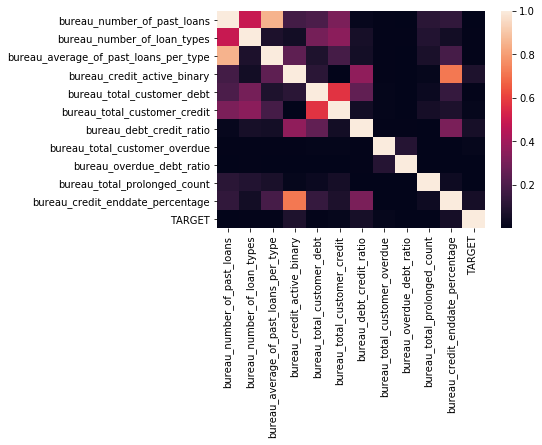

In [31]:
sns.heatmap(X_corr, 
            xticklabels=X_corr.columns,
            yticklabels=X_corr.columns)

In [32]:

BUREAU_AGGREGATION_RECIPIES = [('CREDIT_TYPE', 'count'),
                               ('CREDIT_ACTIVE', 'size')
                               ]
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_ANNUITY',
                   'AMT_CREDIT_SUM',
                   'AMT_CREDIT_SUM_DEBT',
                   'AMT_CREDIT_SUM_LIMIT',
                   'AMT_CREDIT_SUM_OVERDUE',
                   'AMT_CREDIT_MAX_OVERDUE',
                   'CNT_CREDIT_PROLONG',
                   'CREDIT_DAY_OVERDUE',
                   'DAYS_CREDIT',
                   'DAYS_CREDIT_ENDDATE',
                   'DAYS_CREDIT_UPDATE'
                   ]:
        BUREAU_AGGREGATION_RECIPIES.append((select, agg))
        display(BUREAU_AGGREGATION_RECIPIES)
BUREAU_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], BUREAU_AGGREGATION_RECIPIES)]

[('CREDIT_TYPE', 'count'), ('CREDIT_ACTIVE', 'size'), ('AMT_ANNUITY', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max')]

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

[('CREDIT_TYPE', 'count'),
 ('CREDIT_ACTIVE', 'size'),
 ('AMT_ANNUITY', 'mean'),
 ('AMT_CREDIT_SUM', 'mean'),
 ('AMT_CREDIT_SUM_DEBT', 'mean'),
 ('AMT_CREDIT_SUM_LIMIT', 'mean'),
 ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
 ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
 ('CNT_CREDIT_PROLONG', 'mean'),
 ('CREDIT_DAY_OVERDUE', 'mean'),
 ('DAYS_CREDIT', 'mean'),
 ('DAYS_CREDIT_ENDDATE', 'mean'),
 ('DAYS_CREDIT_UPDATE', 'mean'),
 ('AMT_ANNUITY', 'min'),
 ('AMT_CREDIT_SUM', 'min'),
 ('AMT_CREDIT_SUM_DEBT', 'min'),
 ('AMT_CREDIT_SUM_LIMIT', 'min'),
 ('AMT_CREDIT_SUM_OVERDUE', 'min'),
 ('AMT_CREDIT_MAX_OVERDUE', 'min'),
 ('CNT_CREDIT_PROLONG', 'min'),
 ('CREDIT_DAY_OVERDUE', 'min'),
 ('DAYS_CREDIT', 'min'),
 ('DAYS_CREDIT_ENDDATE', 'min'),
 ('DAYS_CREDIT_UPDATE', 'min'),
 ('AMT_ANNUITY', 'max'),
 ('AMT_CREDIT_SUM', 'max'),
 ('AMT_CREDIT_SUM_DEBT', 'max'),
 ('AMT_CREDIT_SUM_LIMIT', 'max'),
 ('AMT_CREDIT_SUM_OVERDUE', 'max'),
 ('AMT_CREDIT_MAX_OVERDUE', 'max'),
 ('CNT_CREDIT_PROLONG', 'max'),
 ('CREDIT_DAY_OVER

In [33]:
BUREAU_AGGREGATION_RECIPIES

[(['SK_ID_CURR'],
  [('CREDIT_TYPE', 'count'),
   ('CREDIT_ACTIVE', 'size'),
   ('AMT_ANNUITY', 'mean'),
   ('AMT_CREDIT_SUM', 'mean'),
   ('AMT_CREDIT_SUM_DEBT', 'mean'),
   ('AMT_CREDIT_SUM_LIMIT', 'mean'),
   ('AMT_CREDIT_SUM_OVERDUE', 'mean'),
   ('AMT_CREDIT_MAX_OVERDUE', 'mean'),
   ('CNT_CREDIT_PROLONG', 'mean'),
   ('CREDIT_DAY_OVERDUE', 'mean'),
   ('DAYS_CREDIT', 'mean'),
   ('DAYS_CREDIT_ENDDATE', 'mean'),
   ('DAYS_CREDIT_UPDATE', 'mean'),
   ('AMT_ANNUITY', 'min'),
   ('AMT_CREDIT_SUM', 'min'),
   ('AMT_CREDIT_SUM_DEBT', 'min'),
   ('AMT_CREDIT_SUM_LIMIT', 'min'),
   ('AMT_CREDIT_SUM_OVERDUE', 'min'),
   ('AMT_CREDIT_MAX_OVERDUE', 'min'),
   ('CNT_CREDIT_PROLONG', 'min'),
   ('CREDIT_DAY_OVERDUE', 'min'),
   ('DAYS_CREDIT', 'min'),
   ('DAYS_CREDIT_ENDDATE', 'min'),
   ('DAYS_CREDIT_UPDATE', 'min'),
   ('AMT_ANNUITY', 'max'),
   ('AMT_CREDIT_SUM', 'max'),
   ('AMT_CREDIT_SUM_DEBT', 'max'),
   ('AMT_CREDIT_SUM_LIMIT', 'max'),
   ('AMT_CREDIT_SUM_OVERDUE', 'max'),
   ('AMT_C

In [34]:
# groupby_cols

In [35]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(BUREAU_AGGREGATION_RECIPIES):
    group_object = bureau.groupby(groupby_cols)
    display(group_object)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        display(groupby_aggregate_name)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        display(application)
        groupby_aggregate_names.append(groupby_aggregate_name)

'SK_ID_CURR_count_CREDIT_TYPE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_size_CREDIT_ACTIVE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_AMT_ANNUITY'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_AMT_CREDIT_SUM'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_AMT_CREDIT_SUM_DEBT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_AMT_CREDIT_SUM_LIMIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_AMT_CREDIT_SUM_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_AMT_CREDIT_MAX_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_CNT_CREDIT_PROLONG'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_CREDIT_DAY_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_DAYS_CREDIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_DAYS_CREDIT_ENDDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_mean_DAYS_CREDIT_UPDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_AMT_ANNUITY'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_AMT_CREDIT_SUM'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_AMT_CREDIT_SUM_DEBT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_AMT_CREDIT_SUM_LIMIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_AMT_CREDIT_SUM_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_AMT_CREDIT_MAX_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_CNT_CREDIT_PROLONG'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_CREDIT_DAY_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_DAYS_CREDIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_DAYS_CREDIT_ENDDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_min_DAYS_CREDIT_UPDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_AMT_ANNUITY'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_AMT_CREDIT_SUM'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_AMT_CREDIT_SUM_DEBT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_AMT_CREDIT_SUM_LIMIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_AMT_CREDIT_SUM_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_AMT_CREDIT_MAX_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_CNT_CREDIT_PROLONG'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_CREDIT_DAY_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_DAYS_CREDIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_DAYS_CREDIT_ENDDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_max_DAYS_CREDIT_UPDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_AMT_ANNUITY'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_AMT_CREDIT_SUM'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_AMT_CREDIT_SUM_DEBT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_AMT_CREDIT_SUM_LIMIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_AMT_CREDIT_SUM_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_AMT_CREDIT_MAX_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_CNT_CREDIT_PROLONG'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_CREDIT_DAY_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_DAYS_CREDIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_DAYS_CREDIT_ENDDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_sum_DAYS_CREDIT_UPDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_AMT_ANNUITY'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_AMT_CREDIT_SUM'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_AMT_CREDIT_SUM_DEBT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_AMT_CREDIT_SUM_LIMIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_AMT_CREDIT_SUM_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_AMT_CREDIT_MAX_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_CNT_CREDIT_PROLONG'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_CREDIT_DAY_OVERDUE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_DAYS_CREDIT'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_DAYS_CREDIT_ENDDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

'SK_ID_CURR_var_DAYS_CREDIT_UPDATE'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12          100016       0         Cash loans           F            N   
13          100017       0         Cash loans           M            Y   
14          100018       0         Cash loans           F            N   
15          100019       0         Cash loans           M            Y   
16          100020       0         Cash loans           M            N   
17          100021       0    Revolving loans           F            N   
18          100022       0    Revolving loans           F            N   
19          100023       0         Cash loans           F            N   
20          100024       0    Revolving loans           M            Y   
21          100025       0         Cash loans           F            Y   
22          100026       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
24          100029       0         Cash loans           M            Y   
25          100030       0         Cash loans           F            N   
26          100031       1         Cash loans           F            N   
27          100032       0         Cash loans           M            N   
28          100033       0         Cash loans           M            Y   
29          100034       0    Revolving loans           M            N   
...            ...     ...                ...         ...          ...   
307481      456225       1         Cash loans           M            N   
307482      456226       0         Cash loans           F            Y   
307483      456227       0         Cash loans           F            N   
307484      456228       0         Cash loans           F            Y   
307485      456229       0    Revolving loans           F            N   
307486      456230       0         Cash loans           F            Y   
307487      456231       0         Cash loans           M            N   
307488      456232       0         Cash loans           F            N   
307489      456233       1         Cash loans           F            N   
307490      456234       0         Cash loans           M            N   
307491      456235       0         Cash loans           M            Y   
307492      456236       0         Cash loans           M            Y   
307493      456237       0         Cash loans           F            N   
307494      456238       0         Cash loans           M            Y   
307495      456239       0         Cash loans           M            Y   
307496      456240       0    Revolving loans           F            N   
307497      456241       0         Cash loans           F            Y   
307498      456242       0         Cash loans           M            Y   
307499      456243       0         Cash loans           F            N   
307500      456244       0         Cash loans           F            N   
307501      456245       0         Cash loans           F            N   
307502      456246       0         Cash loans           F            N   
307503      

In [36]:
groupby_aggregate_names

['SK_ID_CURR_count_CREDIT_TYPE',
 'SK_ID_CURR_size_CREDIT_ACTIVE',
 'SK_ID_CURR_mean_AMT_ANNUITY',
 'SK_ID_CURR_mean_AMT_CREDIT_SUM',
 'SK_ID_CURR_mean_AMT_CREDIT_SUM_DEBT',
 'SK_ID_CURR_mean_AMT_CREDIT_SUM_LIMIT',
 'SK_ID_CURR_mean_AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_CURR_mean_AMT_CREDIT_MAX_OVERDUE',
 'SK_ID_CURR_mean_CNT_CREDIT_PROLONG',
 'SK_ID_CURR_mean_CREDIT_DAY_OVERDUE',
 'SK_ID_CURR_mean_DAYS_CREDIT',
 'SK_ID_CURR_mean_DAYS_CREDIT_ENDDATE',
 'SK_ID_CURR_mean_DAYS_CREDIT_UPDATE',
 'SK_ID_CURR_min_AMT_ANNUITY',
 'SK_ID_CURR_min_AMT_CREDIT_SUM',
 'SK_ID_CURR_min_AMT_CREDIT_SUM_DEBT',
 'SK_ID_CURR_min_AMT_CREDIT_SUM_LIMIT',
 'SK_ID_CURR_min_AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_CURR_min_AMT_CREDIT_MAX_OVERDUE',
 'SK_ID_CURR_min_CNT_CREDIT_PROLONG',
 'SK_ID_CURR_min_CREDIT_DAY_OVERDUE',
 'SK_ID_CURR_min_DAYS_CREDIT',
 'SK_ID_CURR_min_DAYS_CREDIT_ENDDATE',
 'SK_ID_CURR_min_DAYS_CREDIT_UPDATE',
 'SK_ID_CURR_max_AMT_ANNUITY',
 'SK_ID_CURR_max_AMT_CREDIT_SUM',
 'SK_ID_CURR_max_AMT_CREDIT_SUM_D

In [37]:
len(groupby_aggregate_names)

57

In [38]:
application.shape

(307511, 179)

In [39]:
application.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

                 ...                  SK_ID_CURR_var_AMT_CREDIT_SUM  \
0                ...                                   2.133807e+10   
1                ...                                   1.385846e+11   

  SK_ID_CURR_var_AMT_CREDIT_SUM_DEBT SK_ID_CURR_var_AMT_CREDIT_SUM_LIMIT  \
0                       1.208166e+10                        2.558171e+08   
1                       0.000000e+00                        1.640250e+11   

  SK_ID_CURR_var_AMT_CREDIT_SUM_OVERDUE SK_ID_CURR_var_AMT_CREDIT_MAX_OVERDUE  \
0                                   0.0                          5.584936e+06   
1                                   0.0                          0.000000e+00   

  SK_ID_CURR_var_CNT_CREDIT_PROLONG  SK_ID_CURR_var_CREDIT_DAY_OVERDUE  \
0                               0.0                                0.0   
1                               0.0                                0.0   

   SK_ID_CURR_var_DAYS_CREDIT  SK_ID_CURR_var_DAYS_CREDIT_ENDDATE  \
0               186150.000000                        5.890424e+05   
1               827783.583333                        2.228364e+06   

   SK_ID_CURR_var_DAYS_CREDIT_UPDATE  
0                      268865.553571  
1                      824562.000000  

[2 rows x 179 columns]

In [40]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [41]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                    1.000000
SK_ID_CURR_mean_DAYS_CREDIT               0.089729
SK_ID_CURR_min_DAYS_CREDIT                0.075248
SK_ID_CURR_mean_DAYS_CREDIT_UPDATE        0.068927
SK_ID_CURR_sum_DAYS_CREDIT_ENDDATE        0.053735
SK_ID_CURR_max_DAYS_CREDIT                0.049782
SK_ID_CURR_mean_DAYS_CREDIT_ENDDATE       0.046983
SK_ID_CURR_min_DAYS_CREDIT_UPDATE         0.042864
SK_ID_CURR_sum_DAYS_CREDIT                0.042000
SK_ID_CURR_sum_DAYS_CREDIT_UPDATE         0.041404
SK_ID_CURR_var_DAYS_CREDIT                0.038440
SK_ID_CURR_var_DAYS_CREDIT_ENDDATE        0.037370
SK_ID_CURR_max_DAYS_CREDIT_ENDDATE        0.036590
SK_ID_CURR_min_DAYS_CREDIT_ENDDATE        0.034281
SK_ID_CURR_max_DAYS_CREDIT_UPDATE         0.028234
SK_ID_CURR_mean_AMT_CREDIT_SUM            0.019957
SK_ID_CURR_max_AMT_CREDIT_SUM             0.019737
SK_ID_CURR_sum_AMT_CREDIT_SUM             0.014057
SK_ID_CURR_sum_AMT_CREDIT_SUM_OVERDUE     0.013335
SK_ID_CURR_mean_AMT_CREDIT_SUM_

In [42]:
bureau['bureau_credit_type_consumer'] = (bureau['CREDIT_TYPE'] == 'Consumer credit').astype(int)
bureau['bureau_credit_type_car'] = (bureau['CREDIT_TYPE'] == 'Car loan').astype(int)
bureau['bureau_credit_type_mortgage'] = (bureau['CREDIT_TYPE'] == 'Mortgage').astype(int)
bureau['bureau_credit_type_credit_card'] = (bureau['CREDIT_TYPE'] == 'Credit card').astype(int)
bureau['bureau_credit_type_other'] = (~(bureau['CREDIT_TYPE'].isin(['Consumer credit',
                                                        'Car loan', 'Mortgage', 'Credit card']))).astype(int)
bureau['bureau_unusual_currency'] = (~(bureau['CREDIT_CURRENCY'] == 'currency 1')).astype(int)

In [43]:
groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])
group_object = groupby_SK_ID_CURR[['bureau_credit_type_consumer',
                                   'bureau_credit_type_car',
                                   'bureau_credit_type_mortgage',
                                   'bureau_credit_type_credit_card',
                                   'bureau_credit_type_other',
                                   'bureau_unusual_currency']].agg(['sum', 'mean']).reset_index()

group_object.columns = ['{}_{}'.format(a,b) for a,b in group_object.columns.tolist()]
group_object.rename(index=str, columns={'SK_ID_CURR_': 'SK_ID_CURR'},inplace=True)
features = features.merge(group_object, on=['SK_ID_CURR'], how='left')
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary  \
0                               3.666667                     0.545455   
1                               2.000000                     0.500000   
2                               1.000000                     1.000000   
3                               4.000000                     0.375000   
4                               2.666667                     0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  bureau_total_customer_overdue  \
0                  0.047617                            0.0   
1                  0.000000                            0.0   
2                  0.855355                            0.0   
3                  0.430060                            0.0   
4                  0.165538                            0.0   

   bureau_overdue_debt_ratio              ...               \
0                        0.0              ...                
1                        NaN              ...                
2                        0.0              ...                
3                        0.0              ...                
4                        0.0              ...                

   bureau_credit_type_car_sum  bureau_credit_type_car_mean  \
0                           1                     0.090909   
1                           0                     0.000000   
2                           0                     0.000000   
3                           0                     0.000000   
4                           1                     0.125000   

   bureau_credit_type_mortgage_sum  bureau_credit_type_mortgage_mean  \
0                                0                          0.000000   
1                                1                          0.166667   
2                                0                          0.000000   
3                                0                          0.000000   
4                                0                          0.000000   

   bureau_credit_type_credit_card_sum  bureau_credit_type_credit_card_mean  \
0                                   3                             0.272727   
1                                   2                             0.333333   
2                                   0                             0.000000   
3                                   3                             0.375000   
4                                   3                             0.375000   

   bureau_credit_type_other_sum  bureau_credit_type_other_mean  \
0                             0                            0.0   
1                             0                            0.0   
2                             0                            0.0   
3                             0                            0.0   
4                             0                            0.0   

   bureau_unusual_currency_sum  bureau_unusual_currency_mean  
0                            0                           0.0  
1                            0                           0.0  
2                            0                           0.0  
3                            0                           0.0  
4

In [44]:
COLUMN_NAME = 'DAYS_CREDIT_UPDATE'
d = description[description['Row']==COLUMN_NAME]
display(d.Description.tolist())
display(d.Special.tolist())
display(description.head(2))

['How many days before loan application did last information about the Credit Bureau credit come']

['time only relative to the application']

Unnamed: 0                         Table         Row  \
0           1  application_{train|test}.csv  SK_ID_CURR   
1           2  application_{train|test}.csv      TARGET   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN

In [45]:
bureau.sort_values(['SK_ID_CURR','DAYS_CREDIT'],ascending=False, inplace=True)
bureau['days_credit_diff'] = bureau['DAYS_CREDIT'].diff().replace(np.nan, 0)    

groupby_SK_ID_CURR = bureau.groupby(by=['SK_ID_CURR'])

In [46]:
group_object = groupby_SK_ID_CURR['bureau_credit_active_binary'].agg('sum').reset_index()
group_object.rename(index=str, columns={'bureau_credit_active_count': 'bureau_credit_active_binary'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [47]:
group_object = groupby_SK_ID_CURR['SK_ID_BUREAU'].agg('nunique').reset_index()
group_object.rename(index=str, columns={'SK_ID_BUREAU': 'bureau_query_count'},inplace=True)

features = features.merge(group_object, on=['SK_ID_CURR'], how='left')

In [48]:
def last_k_bureau_features(gr, periods):
    gr_ = gr.copy()

    features = {}
    for period in periods:
        if period > 10e10:
            period_name = 'all_records_'
            gr_period = gr_.copy()
        else:
            period_name = 'last_{}_'.format(period)
            gr_period = gr_[gr_['DAYS_CREDIT'] >= (-1) * period]

        features = add_features_in_group(features, gr_period, 'days_credit_diff',
                                             ['sum', 'min', 'max', 'median', 'std'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'CNT_CREDIT_PROLONG',
                                             ['sum', 'std'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_active_binary',
                                             ['sum', 'mean'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_consumer',
                                             ['sum', 'mean'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_car',
                                             ['sum', 'mean'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_credit_card',
                                             ['sum'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_mortgage',
                                             ['sum'],
                                        period_name)
        features = add_features_in_group(features, gr_period, 'bureau_credit_type_other',
                                             ['sum', 'mean'],
                                        period_name)
    return features

def trend_in_last_k_bureau_features(gr, periods):
    gr_ = gr.copy()
    gr_['days_credit_diff'].iloc[0] = 0

    features = {}

    for period in periods:
        gr_period = gr_[gr_['DAYS_CREDIT'] >= (-1) * period]
        features = _add_trend_feature(features,gr_period,
                                      'days_credit_diff','{}_period_trend_'.format(period)
                                     )
    return features


def _add_trend_feature(features, gr ,feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0,len(y)).reshape(-1,1)
        lr = LinearRegression()
        lr.fit(x,y)
        trend = lr.coef_[0]
    except:
        trend=np.nan
    features['{}{}'.format(prefix,feature_name)] = trend
    return features

In [49]:
# print(features.shape)

# copy = features.copy()
# copy_features = groupby_SK_ID_CURR

In [50]:
features.head()

SK_ID_CURR  bureau_number_of_past_loans  bureau_number_of_loan_types  \
0      215354                           11                            3   
1      162297                            6                            3   
2      402440                            1                            1   
3      238881                            8                            2   
4      222183                            8                            3   

   bureau_average_of_past_loans_per_type  bureau_credit_active_binary_x  \
0                               3.666667                       0.545455   
1                               2.000000                       0.500000   
2                               1.000000                       1.000000   
3                               4.000000                       0.375000   
4                               2.666667                       0.625000   

   bureau_total_customer_debt  bureau_total_customer_credit  \
0                   284463.18                    5973945.30   
1                        0.00                    8230386.15   
2                    76905.00                      89910.00   
3                   552730.50                    1285239.06   
4                  1185081.84                    7158960.00   

   bureau_debt_credit_ratio  bureau_total_customer_overdue  \
0                  0.047617                            0.0   
1                  0.000000                            0.0   
2                  0.855355                            0.0   
3                  0.430060                            0.0   
4                  0.165538                            0.0   

   bureau_overdue_debt_ratio         ...          \
0                        0.0         ...           
1                        NaN         ...           
2                        0.0         ...           
3                        0.0         ...           
4                        0.0         ...           

   bureau_credit_type_mortgage_sum  bureau_credit_type_mortgage_mean  \
0                                0                          0.000000   
1                                1                          0.166667   
2                                0                          0.000000   
3                                0                          0.000000   
4                                0                          0.000000   

   bureau_credit_type_credit_card_sum  bureau_credit_type_credit_card_mean  \
0                                   3                             0.272727   
1                                   2                             0.333333   
2                                   0                             0.000000   
3                                   3                             0.375000   
4                                   3                             0.375000   

   bureau_credit_type_other_sum  bureau_credit_type_other_mean  \
0                             0                            0.0   
1                             0                            0.0   
2                             0                            0.0   
3                             0                            0.0   
4                             0                            0.0   

   bureau_unusual_currency_sum  bureau_unusual_currency_mean  \
0                            0                           0.0   
1                            0                           0.0   
2                            0                           0.0   
3                            0                           0.0   
4                            0                           0.0   

   bureau_credit_active_binary_y  bureau_query_count  
0                              6                  11  
1                              3                   6  
2                              1                   1  
3                              3                   8  
4                              5                   8  

[5 rows x 26 columns]

In [51]:
features.to_csv("df_bureau",index=False)

In [52]:
# features.to_csv("df_bureau",index)

In [53]:
features.shape

(305811, 26)

In [54]:
features.dtypes

SK_ID_CURR                                 int64
bureau_number_of_past_loans                int64
bureau_number_of_loan_types                int64
bureau_average_of_past_loans_per_type    float64
bureau_credit_active_binary_x            float64
bureau_total_customer_debt               float64
bureau_total_customer_credit             float64
bureau_debt_credit_ratio                 float64
bureau_total_customer_overdue            float64
bureau_overdue_debt_ratio                float64
bureau_total_prolonged_count               int64
bureau_credit_enddate_percentage         float64
bureau_credit_type_consumer_sum            int32
bureau_credit_type_consumer_mean         float64
bureau_credit_type_car_sum                 int32
bureau_credit_type_car_mean              float64
bureau_credit_type_mortgage_sum            int32
bureau_credit_type_mortgage_mean         float64
bureau_credit_type_credit_card_sum         int32
bureau_credit_type_credit_card_mean      float64
bureau_credit_type_o

In [55]:
# features = copy[:10000].copy()
# groupby_SK_ID_CURR = copy_features
# print(features.shape)
# print(len(groupby_SK_ID_CURR))

In [56]:
# import multiprocessing as mp

# def chunk_groups(groupby_object, chunk_size):
#     n_groups = groupby_object.ngroups
#     group_chunk, index_chunk = [], []
#     for i, (index, df) in enumerate(groupby_object):
#         group_chunk.append(df)
#         index_chunk.append(index)

#         if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
#             group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
#             group_chunk, index_chunk = [], []
#             yield index_chunk_, group_chunk_
            
# def parallel_apply_new(groups, func, index_name='Index', num_workers=1, chunk_size=100000):
#     n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
#     indeces, features = [], []
#     for index_chunk, groups_chunk in tqdm(chunk_groups(groups, chunk_size), total=n_chunks):
#         with mp.pool.Pool(num_workers) as executor:
#             features_chunk = executor.map(func, groups_chunk)
#         features.extend(features_chunk)
#         indeces.extend(index_chunk)
#         print("done")

#     features = pd.DataFrame(features)
#     features.index = indeces
#     features.index.name = index_name
#     print(features.shape)
#     return features

In [57]:
# print("done")
# func = partial(last_k_bureau_features, periods=[60, 180, 360, 720, 1e25])

# g = parallel_apply_new(groupby_SK_ID_CURR, func, index_name='SK_ID_CURR',
#                    num_workers=5, chunk_size=10000).reset_index()
# print("done")
# features = features.merge(g, on='SK_ID_CURR', how='left')

# display(features.head())